In [ ]:
#@title Installation & imports
!pip3 install -U umap-learn > /dev/null

import os 
from pathlib import Path

import numpy as np
import umap.umap_ as umap
import h5py

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

prembs_id = "1MmzlQrc1UXTjG4yMH188cTw4-Lyk1Bfa"
prproj_id = "1Bb05nihdNE_TJURGGECk7Qi6XBorKagR"

pfam_url = "https://raw.githubusercontent.com/sinc-lab/Comparison-of-Protein-learning/master/domains/Pfam_domains.csv"

In [ ]:
#@title Utils
pfams = set({
    "PF07686", 
    "PF07654", 
    "PF00069", 
    "PF07714", 
    "PF00001", 
    "PF13853", 
    "PF00076", 
    "PF00046", 
    "PF00169", 
    "PF00089"
})

pfam2color = {
    "PF07686": "tab:blue", 
    "PF07654": "tab:orange", 
    "PF00069": "tab:green", 
    "PF07714": "tab:red", 
    "PF00001": "tab:purple", 
    "PF13853": "tab:brown", 
    "PF00076": "tab:pink", 
    "PF00046": "black", 
    "PF00169": "tab:olive", 
    "PF00089": "tab:cyan" 
}

pfam2desc = {
    "PF07686": "Immunoglobulin V-set domain.", 
    "PF07654": "Immunoglobulin C1-set domain.", 
    "PF00069": "Protein kinase domain.", 
    "PF07714": "Protein tyrosine and serine/threonine kinase.", 
    "PF00001": "7 transmembrane receptor (rhodopsin family).", 
    "PF13853": "Olfactory receptor.", 
    "PF00076": "RNA recognition motif (a.k.a. RRM, RBD, or RNP domain).", 
    "PF00046": "Homeodomain (Transcription factor).", 
    "PF00169": "Pleckstrin homology domain (intracellular signaling).", 
    "PF00089": "Trypsin (serine protease)."
}

def download_prembs(id):
  """Download protein embeddings"""
  # download embeddings
  if not os.path.exists('prembs'):
    !gdown "https://drive.google.com/uc?id={id}" > /dev/null 2>&1
    !tar xfz prembs.tar.gz

def download_and_read_prprojs(id):
  """Download and read protein projections"""
  if not os.path.exists('prprojs'):
    !gdown "https://drive.google.com/uc?id={id}" > /dev/null 2>&1
    !tar xfz prprojs.tar.gz

  projs = {}
  for path in sorted(Path('prprojs').rglob('*.npy')):
    key = os.path.splitext(path.name)[0]
    projs[key] = np.load(path)

  return projs

def download_and_read_pfam_domains(url, valid_domains):
  """Download pfam domains and create a dict mapping proteins to pfam domains."""
  p2d = {}
  fname = 'Pfam_domains.csv'
  if not os.path.isfile(fname):
    !wget {url} > /dev/null 2>&1

  with open(fname) as f:
    for a in f:
      protid, protname, pfam = a.strip().split(',')
      protid = int(protid) - 1

      if pfam in valid_domains:
        p2d[protid] = pfam
      else:
        if protid not in p2d:
          p2d[protid] = None

  return p2d

## Process Pfam domains
#PF07686 Immunoglobulin V-set domain
#PF07654 Immunoglobulin C1-set domain
#PF00069 Protein kinase domain
#PF07714 Protein tyrosine and serine/threonine kinase
#PF00001 7 transmembrane receptor (rhodopsin family)
#PF13853 Olfactory receptor
#PF00076 RNA recognition motif (a.k.a. RRM, RBD, or RNP domain)
#PF00046 Homeodomain (Transcription factor)
#PF00169 Pleckstrin homology domain (intracellular signaling)
#PF00089 Trypsin (serine protease)

# Ahi hay dos pares de dominios relacionados (PF07686/PF07654 y PF00069/PF07714) y el resto con variedad de funciones y estructuras.

In [ ]:
#@title Project protein sequence embeddings
#@markdown **Note**: Since calculating projections is time-consuming, the projections for the embeddings of 12 different methods were pre-calculated. To force projection calculation, set the variable `force` and re-execute this cell by clicking the botton play on the left margin; cell executation can take at least 10 minutes.

# set to True for calculating to projections
force = False #@param {type:"boolean"}

projs = {}
if force:
  download_prembs(prembs_id)

  for path in sorted(Path('prembs').rglob('*.h5')):
    # read embeddings
    embs = h5py.File(path, 'r')
    keys = list(embs.keys())
    embs = np.asarray([embs[k] for k in keys])

    # projections
    reducer = umap.UMAP(random_state=42)
    proj    = reducer.fit_transform(embs)

    # save projs
    key = os.path.splitext(path.name)[0]
    key = key.split('_')[0]
    projs[key] = proj
else:
  # download precalculated projections
  projs = download_and_read_prprojs(prproj_id)

Immunoglobulin C1-set domain.


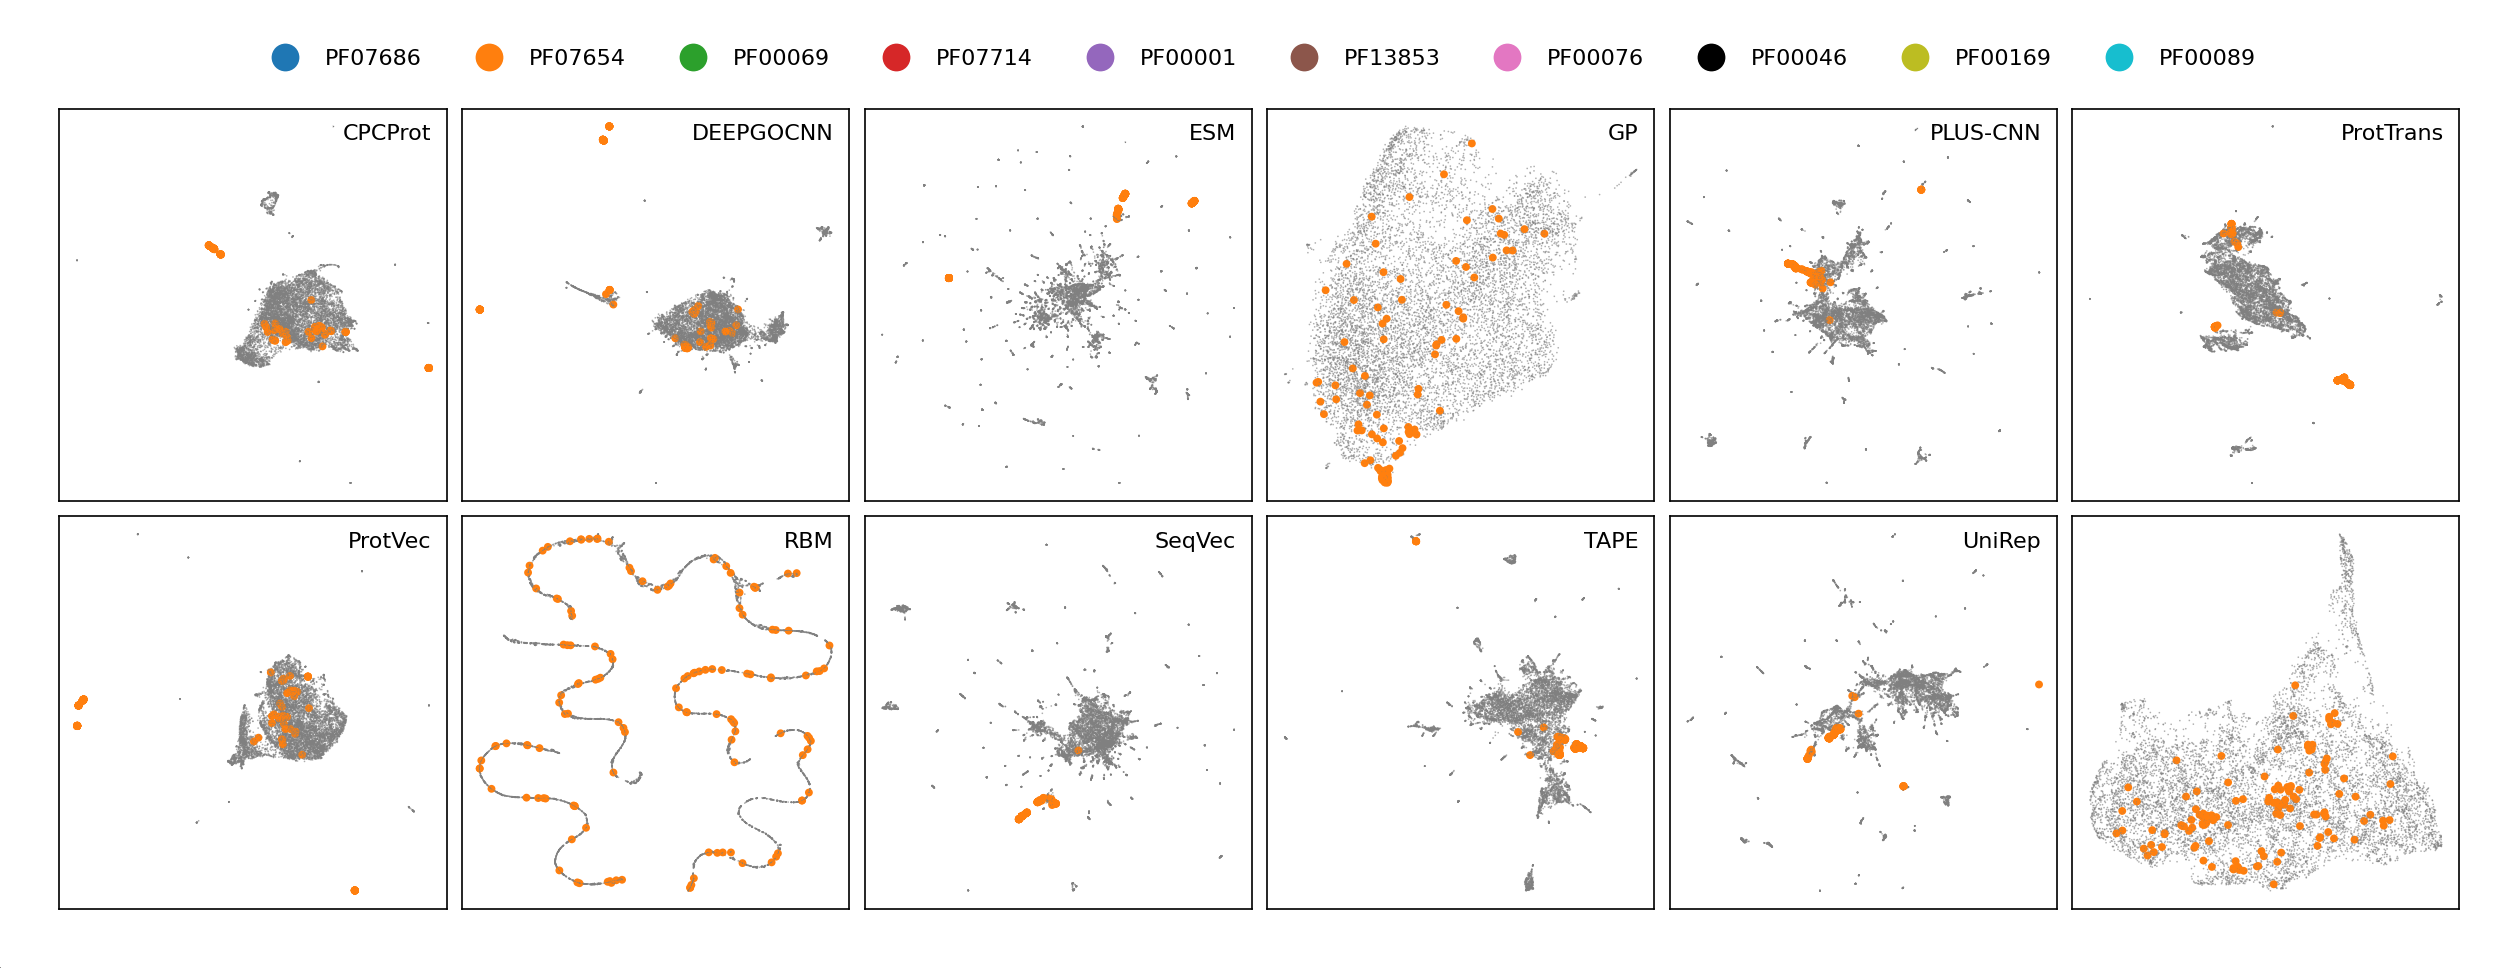

In [ ]:
#@title Visualize projections with a given Pfam domain { run: "auto" }
#@markdown Select Pfam domain to be highlighted.

#@markdown ---
pfam_domain = 'PF07654' #@param ["PF07686", "PF07654", "PF00069", "PF07714", "PF00001", "PF13853", "PF00076", "PF00046", "PF00169", "PF00089", "ALL"]
#@markdown ---

if pfam_domain != 'ALL':
  print(pfam2desc[pfam_domain])

# Define color mappings
emb = list(projs.values())[0]
nembs = emb.shape[0]

# dict mapping proteins to pfam domains
p2d = download_and_read_pfam_domains(pfam_url, pfams)

# highlight embeddings containing input Pfam domain
colors = []
psizes = []
for i in range(nembs):
  color = 'gray'
  size  = .01

  if i in p2d:
    if pfam_domain == "ALL":
      if p2d[i] in pfam2color:
        color = pfam2color[p2d[i]]
        size  = 2.
    elif p2d[i] == pfam_domain:
      color =  pfam2color[pfam_domain]
      size  = 2.

  psizes.append(size)
  colors.append(color)

plt.rcParams.update({'font.size': 4})
fig, axs = plt.subplots(2, 6, figsize=(6,2), dpi=400, linewidth=.1)
plt.subplots_adjust(left=0,
                    right=1,
                    bottom=0,
                    top=1,
                    wspace=.04, 
                    hspace=.04)

keys = list(projs.keys())
k = 0
nrows = 2
ncols = 6
for i in range(nrows):
  for j in range(ncols):
    pname = keys[k]
    proj = projs[keys[k]]
    axs[i][j].scatter(proj[:,0], 
                      proj[:,1], 
                      s=.1,
                      c='gray',
                      alpha=.5, 
                      edgecolor='none',
                      zorder=-1)
    axs[i][j].scatter(proj[:,0], 
                      proj[:,1], 
                      s=psizes, 
                      c=colors,
                      edgecolor='none',
                      label=pname,
                      zorder=10)
    #axs[i][j].axis('off')
    axs[i][j].xaxis.set_ticklabels([])
    axs[i][j].yaxis.set_ticklabels([])
    axs[i][j].set_xticks([])
    axs[i][j].set_yticks([])

    axs[i][j].spines['bottom'].set_linewidth(.3)
    axs[i][j].spines['left'].set_linewidth(.3)
    axs[i][j].spines['top'].set_linewidth(.3)
    axs[i][j].spines['right'].set_linewidth(.3)

    axs[i][j].legend(loc="upper right", 
                     scatterpoints=0,
                     borderpad=0.2, 
                     edgecolor='none')
    
    k += 1

# Custom legend
leg_elems = [Line2D([0], [0], 
                    marker='o', 
                    color='none',
                    linewidth=0,
                    markeredgecolor='none',
                    label=p,
                    markerfacecolor=c, 
                    markersize=5) for p, c in pfam2color.items()]
plt.legend(handles=leg_elems, 
           loc='upper center', 
           bbox_to_anchor=(0.5, 1.1),
           bbox_transform=plt.gcf().transFigure,
           frameon=False,
           ncol=len(pfam2color))

# uncomment lines below to save the plot into a pdf file
# plt.savefig('premb_projs.pdf', 
#             dpi=300, 
#             bbox_inches='tight', 
#             pad_inches = 0.02) 

plt.show()